# Radiative Cooling Demo
This notebook will build the multi-layer structure described in Raman $et$ $al.$, Nature 515, 540-546 (2014), compute plot its emissivity in the solar region and in the atmospheric transmissivity region of the spectrum (~300-2500 nm for the former, 2500-20000 nm for the latter), and compute the cooling power for several different differences between the temperature of the structure and the ambient temperature.  

Two differences between this notebook and the structure described in Raman $et$ $al.$ to note: (1) in this example, we terminate the multilayer at the optically thick Ag layer; the full structure described by Raman $et$ $al.$ involved was grown on a silicon substrate and included a thin (10 nm) titanium adhesion layer. Due to the very small skin depth of silver in the visible and IR, these layers make virtually no contribution to the optical properties of the stack.  To confirm there is negligible transmission through the terminal silver layer, one can plot the transmissivity of the multilayer by uncommenting the indicated lines below to confirm no visible or IR light is transmissited through the stack. (2) The refractive index data for materials described by Raman $et$ $al.$ are determined by ellipsometry on as-fabricated materials, and likely differ from the refractive index data employed by WPTherml. 

In [ ]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np

test_args = {
    'Material_List': ['Air', 'SiO2', 'HfO2', 'SiO2', 'HfO2', 'SiO2', 'HfO2', 'SiO2', 'Ag', 'Air'],
    'Thickness_List': [0, 230e-9, 485e-9, 688e-9, 13e-9, 73e-9, 34e-9, 54e-9, 200e-9, 0],
    'Wavelength_List': [300e-9, 30000e-9, 2000], # note new name for this key
    "cooling": True # note use of boolean not integer now
}

# start the spectrum factory
sf = wptherml.SpectrumFactory()
# create an instance using the TMM with the structure defined as above
cool_ml = sf.spectrum_factory('Tmm', test_args)




The instance `cool_ml` will have a number of attributes computed automatically when 
`cooling = True`, including
the emissivity spectrum (`cool_ml.emissivity_array`), the reflectivity spectrum (`cool_ml.reflectivity_array`), and the transmissivity spectrum (`cool_ml.transmissivity_array`).  The data associated with the solar spectrum and the atmospheric transmissivity is stored as the attributes `cool_ml._solar_spectrum` and
`cool_ml._atmospheric_transmissivity`, respectively.  We plot key spectra below.

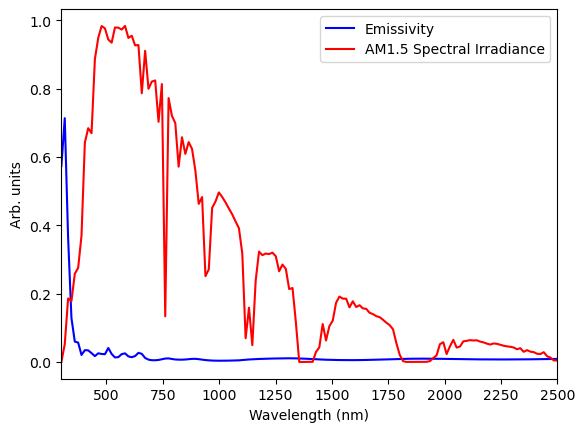

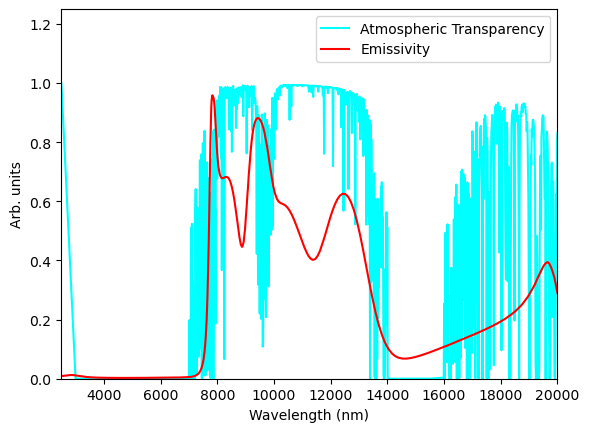

In [2]:
### plot emissivity of cool_ml against AM1.5 spectrum in the visible range
### to demonstrate the high solar reflectivity of cool_ml
plt.plot(cool_ml.wavelength_array*1e9, cool_ml.emissivity_array, 'blue', label='Emissivity')
plt.plot(cool_ml.wavelength_array*1e9, cool_ml._solar_spectrum/(1.4*1e9), 'red', label='AM1.5 Spectral Irradiance')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Arb. units")
plt.legend(loc = 'best')
plt.xlim(300,2500)
plt.show()

### plot the emissivity of cool_ml against the atmospheric transmissivity in the IR
### to demonstrate the selective thermal emissivity of cool_ml
plt.plot(cool_ml.wavelength_array*1e9, cool_ml._atmospheric_transmissivity, 'cyan', label='Atmospheric Transparency')
plt.plot(cool_ml.wavelength_array*1e9, cool_ml.emissivity_array, 'red', label='Emissivity')
### Uncomment the next line if you want to plot the transmissivity of
### the multilayer in the IR
#plt.plot(cool_ml.lambda_array*1e9, cool_ml.transmissivity_array, 'green', label='Transmissivity')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Arb. units")
plt.legend(loc = 'best')
plt.xlim(2500,20000)
plt.ylim(0,1.25)
plt.show()

Let's look at the quantities $P_{rad}$, $P_{sun}$, $P_{atm}$, and $P_{cool}$, which are
also computed and stored as attributes.
- $P_{rad}$ is the power radiated from the structure to the sky, stored in the attribute `self.radiative_cooling_power`
- $P_{sun}$ is the solar power absorbed by the structure, stored in the attribute `self.solar_warming_power`
- $P_{atm}$ is the atmospheric radiation absorbed by the structure, stored in the attribute `self.atmospheric_warming_power`
- $P_{cool} = P_{rad} - P_{sun} - P_{atm}$ is stored in `self.net_cooling_power`

In [3]:
print("P_rad is ",cool_ml.radiative_cooling_power)
print("P_sun is ",cool_ml.solar_warming_power)
print("P_atm is ",cool_ml.atmospheric_warming_power)
print("P_cool is ",cool_ml.net_cooling_power)

P_rad is  123.13268147179986
P_sun is  13.408193615615852
P_atm is  37.50945781164125
P_cool is  72.21503004454274


# Manipulating the structure: adding and removing layers

Let's say we want to insert a 100 nm layer in between layer 1 and layer 2, we can do so using the `.insert_layer(layer_number, layer_thickness)` method as 
with `layer_number = 2` and `layer_thickness=100e-9` as follows:

In [4]:
# print thickness list before adding layer
ln = len(cool_ml.thickness_array)-1
print(" printing thickness array before inserting new layer")
print(cool_ml.thickness_array * 1e9)
cool_ml.insert_layer(ln, 123e-9)
print(" printing thickness array after inserting new layer")
print(cool_ml.thickness_array * 1e9)

 printing thickness array before inserting new layer
[  0. 230. 485. 688.  13.  73.  34.  54. 200.   0.]
 A  1.23e-07  m air layer has been inserted into layer numbe  9
 Use the `material_X( 9 ) command to define the material of this new layer!
 printing thickness array after inserting new layer
[  0. 230. 485. 688.  13.  73.  34.  54. 200. 123.   0.]


Right now the new layer 2 is just vacuum (refractive index = 1+0i for all wavelengths).  We can associate layer 2 with a supported material using any of the `.material_X(layer_number)` methods.  To see the full list of supported materials, start typing `cool_ml.material_` and press tab to see options.  

In [5]:
cool_ml.material_Al2O3(2)
cool_ml.compute_cooling()

In [6]:
print("P_rad is ",cool_ml.radiative_cooling_power)
print("P_sun is ",cool_ml.solar_warming_power)
print("P_atm is ",cool_ml.atmospheric_warming_power)
print("P_cool is ",cool_ml.net_cooling_power)

P_rad is  118.94639903879138
P_sun is  14.191129956241605
P_atm is  36.33517454176449
P_cool is  68.42009454078529


# Custom materials 
You can add custom materials provided you have a refractive index data file in the directory `/wptherml/data` that contains as column 1 the wavelength in meters, in column 2 the real part of the refractive index, and as column 3 the imaginary part of the refractive index.  To define a layer with the refractive index data coming from a custom file, issue the `.material_from_file(layer_number, file_name)` argument.  Here we will use data stored in a file "SiO2_ir.txt" to define the material in layer 2.

In [7]:
# go back to SiO2 for the top layer
cool_ml.material_from_file(2, "SiO2_ir.txt")
cool_ml.compute_cooling()

In [8]:
print("P_rad is ",cool_ml.radiative_cooling_power)
print("P_sun is ",cool_ml.solar_warming_power)
print("P_atm is ",cool_ml.atmospheric_warming_power)
print("P_cool is ",cool_ml.net_cooling_power)

P_rad is  140.83729645580192
P_sun is  13.987195420408222
P_atm is  45.66942158727352
P_cool is  81.18067944812017


We can also remove layers using the `.remove_layer(layer_number)` method.  Again, we will remove the layer we just added, returing us to the original stack.

In [9]:
# print thickness list before adding layer
print(" printing thickness array before removing layer 2")
print(cool_ml.thickness_array * 1e9)
cool_ml.remove_layer(2)
print(" printing thickness array after removing layer 2")
print(cool_ml.thickness_array * 1e9)

 printing thickness array before removing layer 2
[  0. 230. 485. 688.  13.  73.  34.  54. 200. 123.   0.]
 printing thickness array after removing layer 2
[  0. 230. 688.  13.  73.  34.  54. 200. 123.   0.]


# Manipulating the structure: Changing thickness of a single layer

If you want to set the thickness of individual layers and then update the quantities (e.g. for brute-force searchers), you can access the layer thicknesses through the `.thickness_array` attribute, and you can issue the `.compute_cooling()` method to update all of the calculations after modifying the thickness.  The following line will update the thickness of layer 1 to be 150 nanometers, and then update and print the cooling figures of merit.

In [10]:
cool_ml.thickness_array[1] = 100e-9
cool_ml.compute_cooling()
print("P_rad is ",cool_ml.radiative_cooling_power)
print("P_sun is ",cool_ml.solar_warming_power)
print("P_atm is ",cool_ml.atmospheric_warming_power)
print("P_cool is ",cool_ml.net_cooling_power)

P_rad is  78.76583415015567
P_sun is  14.086172427981811
P_atm is  26.034092327977593
P_cool is  38.64556939419627


# Manipulating the structure: Gradient-based optimization
We have implemented analytic gradients of the transfer matrix equations, which also enables analytic gradients of figures of merit based on the reflectivity, emissivity, and/or transmissivity (see details [here](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.013018)).  Here we have a high-level method called `.compute_cooling_gradient()` that will compute the gradients of $P_{cool}, P_{rad}, P_{sun}, P_{atm}$ with respect to the thickenss of each layer.  This can be used to do gradient-based local optimizations of structures for any of these desired figures of merit.  You can also leverage these in global optimizations that perform multiple gradient-based optimizations, with one example being the Basin Hopping algorithm.  Here we will demonstrate the local gradient-based optimization using the L-BFGS-B method, where this algorithm also supports upper- and lower-bounds on the layer thicknesses so that the structures geometries can be constrained to be realistic.  

**These calculations are a bit slower than single evaluations, so run with care.**

The gradient vectors for each of the radiative cooling quantities are stored in attributes as follows:

$ P'_{cool} \rightarrow$ `.net_cooling_power_gradient`

$ P'_{rad} \rightarrow$ `.radiative_cooling_power_gradient` 

$ P'_{sun} \rightarrow$ `.solar_warming_power` 

$ P'_{atm} \rightarrow$ `.atmospheric_warming_power`

The L-BFGS-B algorithm can be accessed using the scipy.optimize library, and requires a callable function that returns the objective function to be optimized along with the gradient vector of the objective.  The following functions are implemented within this notebook in support of the L-BFGS-B updates:
- `update_multilayer(x)` returns the objective function when given an array of layer thicknesses (expected in nanometers for this function)
- `analytic_grad(x)` returns the gradient vector of the obective when given an array of layer thicknesses (expected in nanometers for this function); the gradient is scaled so that it is in per nm instead of per m.
- `SuperFunc(x)` returns both the gradient vector and the objective function; this is the callable function that the L-BFGS-B routine will use


In [ ]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import time

test_args = {
    'Material_List': ['Air', 'SiO2', 'HfO2', 'SiO2', 'HfO2', 'SiO2', 'HfO2', 'SiO2', 'Ag', 'Air'],
    'Thickness_List': [0, 230e-9, 485e-9, 688e-9, 13e-9, 73e-9, 34e-9, 54e-9, 200e-9, 0],
    'Wavelength_List': [300e-9, 60000e-9, 5000], # note new name for this key
    "cooling": True # note use of boolean not integer now
}

# start the spectrum driver
sf = wptherml.SpectrumFactory()
# create an instance using the TMM with the structure defined as above
cool_ml = sf.spectrum_factory('Tmm', test_args)

def update_multilayer(x):
    """ function to update the thicknesses of each layer given an
        array of thicknesses stored in x"""
    
    cool_ml.thickness_array[1:cool_ml.number_of_layers-1] = x * 1e-9
    cool_ml.compute_cooling()

    ### return negative of cooling power - minimize functions want 
    ### to minimize, so trick them by passing negative of the objective you
    ### want to maximize
    return -cool_ml.net_cooling_power

### given an array of thicknesses of the coating, update
### the structure and compute the gradient vector of conversion efficiency wrt layer thicknesses
def analytic_grad(x0):
    cur = update_multilayer(x0)
    cool_ml.compute_cooling_gradient()

    g = cool_ml.net_cooling_power_gradient
    ### scale gradient to be in nm^-1 rather than over m^-1
    return -g*1e-9

### Function that gets the negative of the efficiency and the 
### negative of the gradient for use in the l-bfgs-b algorithm
### also prints out the time for timing purposes!
def SuperFunc(x0):
    en = update_multilayer(x0)
    c_time = time.time()
    if en<0:
        print(" This structure is net cooling with net power out being",-en)
    else:
        print(" This structure is net warming with net poer in being",-en)
    gr = analytic_grad(x0)
    return en, gr

# the bounds for L-BFGS-B updates!
# minimum layer thickness is 1 nm
bfgs_xmin = np.ones(cool_ml.number_of_layers-2)
# maximum layer thickness is 400 nm
bfgs_xmax = 400*np.ones(cool_ml.number_of_layers-2)

# rewrite the bounds in the way required by L-BFGS-B
bfgs_bounds = [(low, high) for low, high in zip(bfgs_xmin, bfgs_xmax)]

### initialize the solution vector xs to be the thicknesses from 
### Raman et al. paper
xs = np.array([230, 485, 688, 13, 73, 34, 54, 200])
### print out initial solution vector and initial efficiency
print("xs is ")
print(xs)
pflux = -update_multilayer(xs)
if pflux>0:
    print(" This structure is net cooling with net power out being",pflux)   
else:
    print(" This structure is net warming with net poer in being",pflux)


### run l-bfgs-b algorithm!
ret = minimize(SuperFunc, xs, method="L-BFGS-B", jac=True, bounds=bfgs_bounds)

### print optimal solution and its efficiency!
print(ret.x)
print(-update_multilayer(ret.x))